In [1]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
results = ap.DataDict.load('BoidsModel')

Loading from directory ap_output/BoidsModel_2/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [4]:
X =  results.reporters[['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']]
Y = results.reporters[['final_alignment', 'final_cohesion', 'final_separation_avg', 'final_border_distance_avg']]

In [5]:
# Split the data into training+validation set and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the training+validation set into separate training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

# # Convert the datasets to PyTorch tensors
# X_train = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
# X_val = torch.tensor(X_val.values, dtype=torch.float32)
# Y_val = torch.tensor(Y_val.values, dtype=torch.float32)
# X_test = torch.tensor(X_test.values, dtype=torch.float32)
# Y_test = torch.tensor(Y_test.values, dtype=torch.float32)

# Convert pandas dataframes to numpy arrays (if not already in numpy format)
X_train_np = X_train.values
Y_train_np = Y_train.values
X_val_np = X_val.values
Y_val_np = Y_val.values
X_test_np = X_test.values
Y_test_np = Y_test.values

# Initialize scalers for X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_np)
Y_train_scaled = scaler_Y.fit_transform(Y_train_np)

# Transform the validation and test data
X_val_scaled = scaler_X.transform(X_val_np)
Y_val_scaled = scaler_Y.transform(Y_val_np)
X_test_scaled = scaler_X.transform(X_test_np)
Y_test_scaled = scaler_Y.transform(Y_test_np)

# Convert the numpy arrays back to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val = torch.tensor(Y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test = torch.tensor(Y_test_scaled, dtype=torch.float32)

In [6]:
# Neural Network Architecture
class ForwardModel(nn.Module):
    def __init__(self, X, Y):
        super(ForwardModel, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x
    
# Neural Network Architecture
class InverseModel(nn.Module):
    def __init__(self, X, Y):
        super(InverseModel, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [18]:
forward_model = ForwardModel(X_train, Y_train)
inverse_model = InverseModel(Y_train, X_train)

forward_criterion = nn.MSELoss()
inverse_criterion = nn.MSELoss()

forward_optimizer = optim.Adam(forward_model.parameters(), lr=0.001)
inverse_optimizer = optim.Adam(inverse_model.parameters(), lr=0.001)

In [19]:
# for epoch in range(1000):
#     # Train forward model
#     forward_optimizer.zero_grad()
#     forward_output = forward_model(X_train)
#     forward_loss = forward_criterion(forward_output, Y_train)
#     forward_loss.backward()
#     forward_optimizer.step()

#     # Use the predicted final state as input for the inverse model
#     inverse_optimizer.zero_grad()
#     inverse_output = inverse_model(forward_output.detach())
#     inverse_loss = inverse_criterion(inverse_output, X_train)
#     inverse_loss.backward()
#     inverse_optimizer.step()

#     # Logging the losses
#     if epoch % 100 == 0:
#         print(f'Epoch {epoch+1}, Forward Loss: {forward_loss.item()}, Inverse Loss: {inverse_loss.item()}')

for epoch in range(1000):
    # Train forward model with the goal of providing good inputs to the inverse model
    forward_optimizer.zero_grad()
    forward_output = forward_model(X_train)
    
    # Detach forward output to prevent gradients from flowing into the forward model during inverse model training
    inverse_optimizer.zero_grad()
    reconstructed_X = inverse_model(forward_output.detach())
    
    # The loss is how well the inverse model can reconstruct the original X from the forward model's output
    cycle_loss = inverse_criterion(reconstructed_X, X_train)
    cycle_loss.backward()  # Backpropagate errors through the inverse model
    inverse_optimizer.step()
    
    # Now we update the forward model to reduce the cycle loss
    # This requires gradients from the inverse model's predictions, hence no detach is used here
    forward_loss = inverse_criterion(inverse_model(forward_output), X_train)
    forward_loss.backward()  # Backpropagate errors through the forward model
    forward_optimizer.step()

    # Logging the losses
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Cycle Loss: {cycle_loss.item()}')


Epoch 1, Cycle Loss: 1.0229605436325073
Epoch 101, Cycle Loss: 0.06262483447790146
Epoch 201, Cycle Loss: 0.13751152157783508
Epoch 301, Cycle Loss: 0.17118936777114868
Epoch 401, Cycle Loss: 0.04335762932896614
Epoch 501, Cycle Loss: 0.1417701691389084
Epoch 601, Cycle Loss: 0.08371919393539429
Epoch 701, Cycle Loss: 0.18552429974079132
Epoch 801, Cycle Loss: 0.17442049086093903
Epoch 901, Cycle Loss: 0.336968332529068


In [20]:
forward_model.eval()  # Set the model to evaluation mode
inverse_model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Do not calculate gradients to save memory
    # Calculate the predictions for the test set
    Y_pred = forward_model(X_test)
    X_pred = inverse_model(Y_test)

    # Calculate the loss for the test set
    forward_test_loss = forward_criterion(Y_pred, Y_test)
    inverse_test_loss = inverse_criterion(X_pred, X_test)

print(f'Forward test loss: {forward_test_loss.item()}')
print(f'Inverse test loss: {inverse_test_loss.item()}')

Forward test loss: 65.529541015625
Inverse test loss: 9.560381889343262


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predictions for the test set
Y_pred = forward_model(X_test)
X_pred = inverse_model(Y_test)

# Convert the predictions and true values to NumPy arrays
Y_pred_np = Y_pred.detach().numpy()
Y_test_np = Y_test.numpy()
X_pred_np = X_pred.detach().numpy()
X_test_np = X_test.numpy()

# Calculate the metrics
mae_forward = mean_absolute_error(Y_test_np, Y_pred_np)
mse_forward = mean_squared_error(Y_test_np, Y_pred_np)
r2_forward = r2_score(Y_test_np, Y_pred_np)

mae_inverse = mean_absolute_error(X_test_np, X_pred_np)
mse_inverse = mean_squared_error(X_test_np, X_pred_np)
r2_inverse = r2_score(X_test_np, X_pred_np)

print(f'MAE: {mae_forward}, MSE: {mse_forward}, R^2: {r2_forward}')
print(f'MAE: {mae_inverse}, MSE: {mse_inverse}, R^2: {r2_inverse}')

MAE: 6.781585693359375, MSE: 65.52954864501953, R^2: -68.29176617974886
MAE: 2.4145615100860596, MSE: 9.560383796691895, R^2: -8.885936299301456


/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

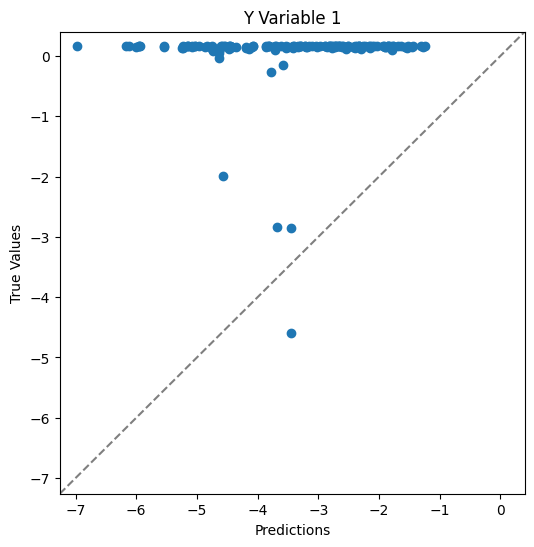

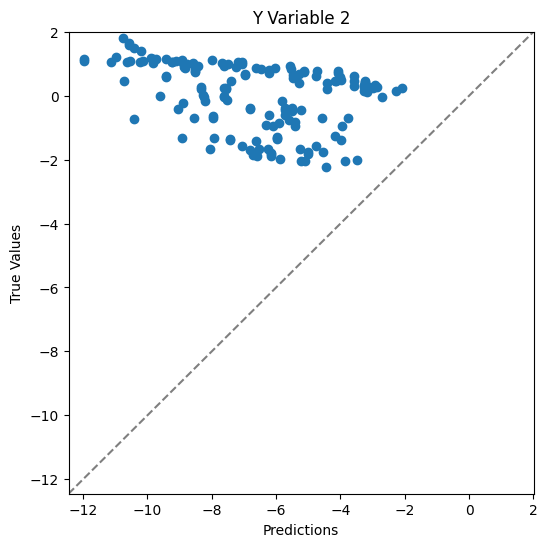

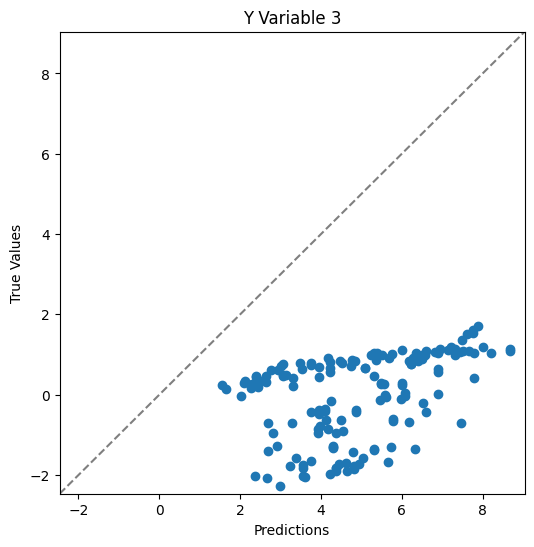

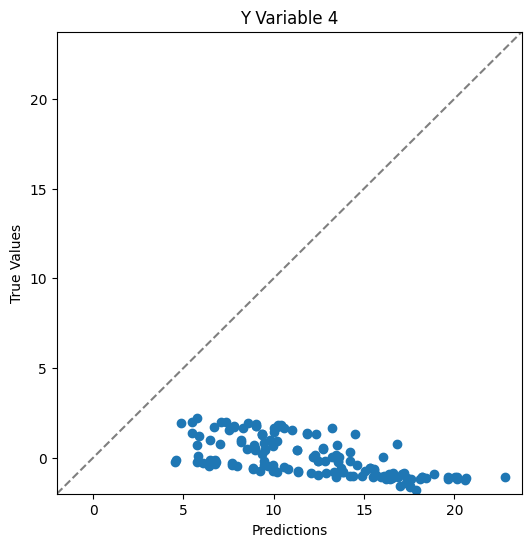

In [22]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred_np[:, i], Y_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()

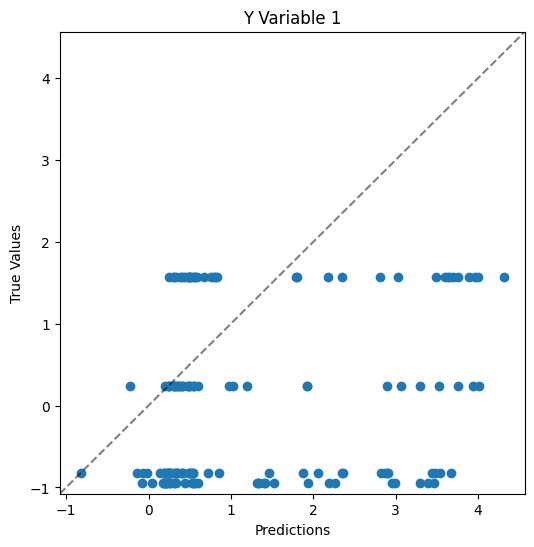

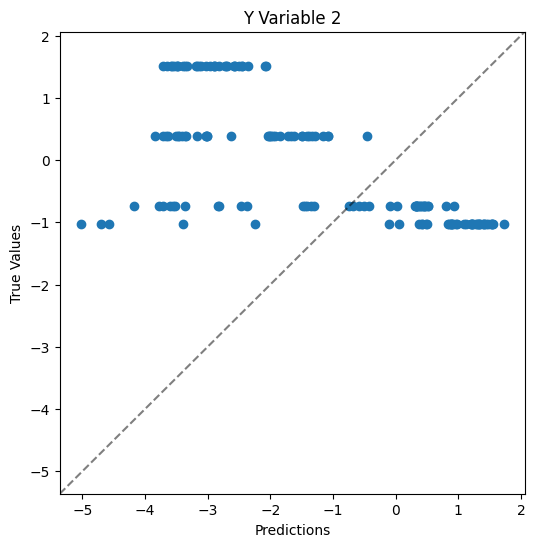

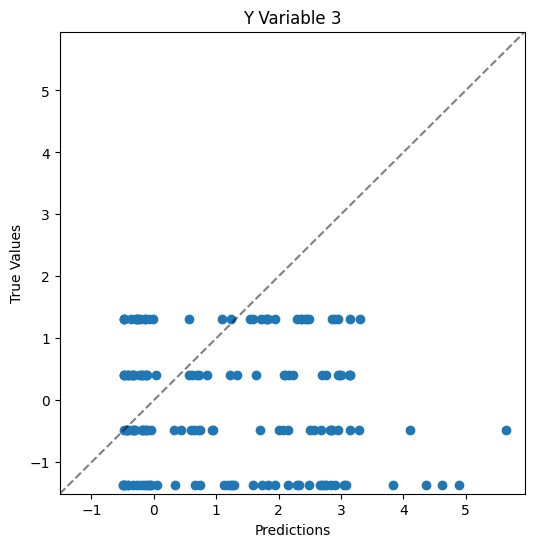

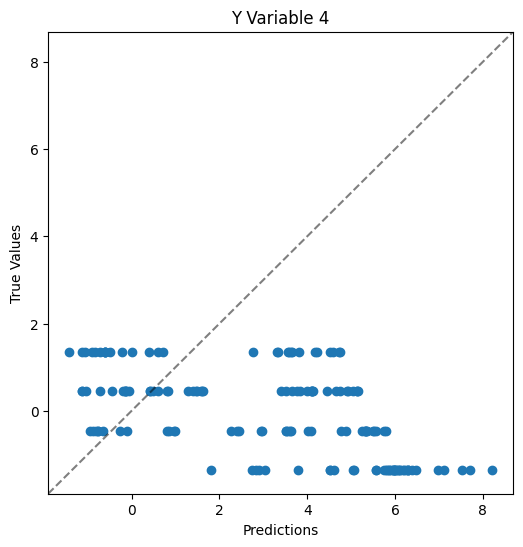

In [23]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(X_pred_np[:, i], X_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()